# Neural Style Transfer
En el pdf de la actividad se describe brevemente el método de generación de imágenes **Neural Style Transfer**. No se pretende adquirir un conocimiento profundo de este método sino utilizar la práctica para adquirir un **conocimiento intuitivo de las Redes Neuronales Convolucionales como extractores de características**.

En primer lugar, importamos PyTorch junto con otros paquetes.

In [ ]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Transfer Learning: descargamos VGG19
En esta actividad vamos a utilizar el primer bloque de VGG19, que sirve para **extraer las características** de la imagen de entrada

In [ ]:
# reutilizamos el modelo pre-entrenado VGG19
vgg_all = models.vgg19(pretrained=True)

# pero seleccionamos solo el primer bloque de la red que extrae features
vgg_features = vgg_all.features

# congelamos porque solo queremos optimizar la imagen target
for param in vgg_features.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## VGG19 - Clasificador
Aunque en esta práctica solo vamos a utilizar el bloque extractor de características, podemos aprovechar para echarle un vistazo al bloque de **clasificación**.

Comprobamos que el segundo bloque, el clasificador, está compuesto por:
* capas lineales (Linear)
* funciones de activación ReLU
* capas de dropout para evitar overfitting

Si quisiéramos utilizar VGG19 como clasificador de un dataset de imágenes, deberíamos sustituir este bloque por otro similar con tantas salidas como clases haya en el dataset.

In [ ]:
vgg_classifier = vgg_all.classifier
print(vgg_classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


## Pasamos modelo a GPU si está disponible

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg_features.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## load_image
Función para cargar una imagen

In [ ]:
def load_image(img_path, max_size=300, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= max_size pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    # VGG está normalizada con los valores de Imagenet: 0.406, 0.456, 0.485 en BGR, que invertimos en RGB.
    # En rango 0-255 seria 103.94, 116.78, 123.68 en BGR
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # con :3 eliminamos el último canal de la primera dimensión, que es el alfa e indica la transparencia
    # con unsqueeze(0) añadimos como primera dimensión el batch
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

## Carga de las imágenes de contenido y estilo
Además, cambiamos tamaño de la imagen de estilo a la de contenido.

In [ ]:
# cargamos las imágenes de contenido y estilo
img_quinta = "https://github.com/albertojulian/master-ub/raw/main/quinta.jpeg"
img_palamos = "https://github.com/albertojulian/master-ub/raw/main/playa_palamos.jpg"
img_soto = "https://github.com/albertojulian/master-ub/raw/main/soto_cruz_mazo.jpg"

content = load_image(img_palamos).to(device)

img_van_gogh = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
img_kandinsky = "https://www.wassilykandinsky.net/images/works/36.jpg?version=7"

# cambia tamaño de la imagen de estilo: coge los dos últimos valores de shape de la imagen de contenido
style = load_image(img_kandinsky, shape=content.shape[-2:]).to(device)

## im_convert
Es una función de ayuda para pasar una imagen de Tensor a numpy y poderla visualizar

In [ ]:
def im_convert(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0) # cambia ancho por alto
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

## Veamos las imágenes de contenido y estilo

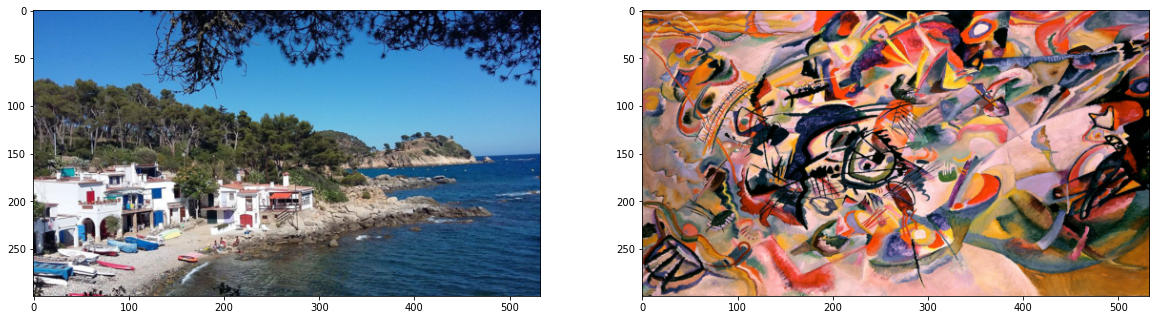

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## Capas de vgg_features
Veamos los identificadores de capas del extractor de características, vgg_features

In [ ]:
print(vgg_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Extracción de características
La función get_features se utiliza para extraer las características de las imágenes de contenido y estilo.

En primer lugar, filtramos las capas que vamos a tener en cuenta para la extracción de características según se indica en el artículo de referencia. Utilizaremos varias capas para el estilo pero solo una (conv4_2) para el contenido.

A continuación, extraemos las características de la imagen para las capas seleccionadas.

In [ ]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## contenido
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules es un diccionario con todas las capas
    for name, layer in model._modules.items():
        x = layer(x) # la imagen se va transformando en cada capa...
        if name in layers: # ...pero solo extraemos las características de las capas seleccionadas
            features[layers[name]] = x

    return features


## Matriz Gram
El método Style Transfer utiliza la matriz Gram o Gramian para procesar las características.

Ver https://en.wikipedia.org/wiki/Gramian_matrix

In [ ]:
def gram_matrix(tensor):

    # obtenemos batch_size, depth, height y width del Tensor
    b, d, h, w = tensor.size()

    # convertimos el tensor a 2D multiplicando dimensiones entre sí
    tensor = tensor.view(b * d, h * w)

    # calculamos la matriz gram multiplicando el tensor por su transpuesto
    gram = torch.mm(tensor, tensor.t())

    return gram

## Definimos los parámetros a probar
* Definimos los pesos de las capas de estilo. Excluimos conv4_2 porque es la capa de la que extraemos el contenido.
* Definimos valores de los pesos de contenido y estilo para la función de pérdida (content_weight, style_weight).
* Definimos la tasa de aprendizaje.
* Definimos el número de iteraciones (steps)


In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

learning_rate = 0.1

steps = 500 # número de iteraciones

# definimos cada cuántas imágenes queremos hacer una visualización intermedia
show_every = 100

## Inicialización y entrenamiento del modelo
Tareas:
* definimos las capas del nuevo modelo
* inicializamos la imagen generada con la imagen de contenido
* definimos el optimizador
* modificamos la imagen generada mediante la función de pérdida, compuesta por la suma de la pérdida de estilo y la de contenido ponderadas

Pérdida total:  2893370.5


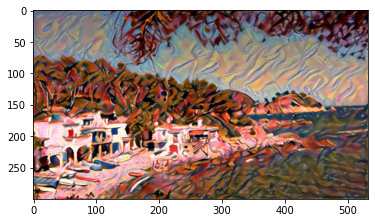

Pérdida total:  1299626.875


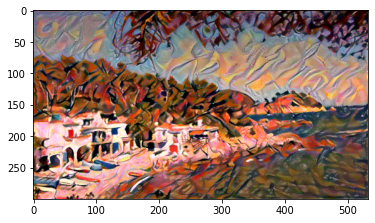

Pérdida total:  988367.8125


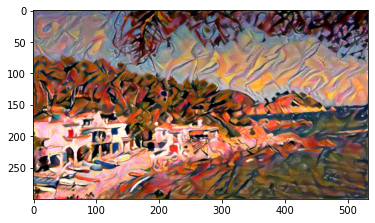

Pérdida total:  2266106.5


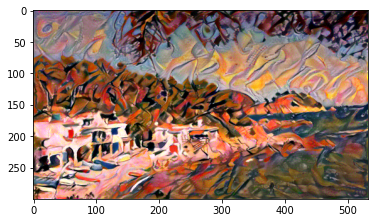

Pérdida total:  622307.0625


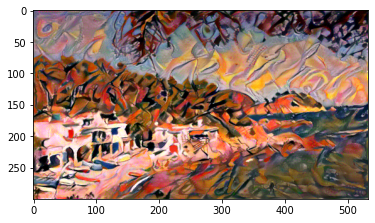

In [ ]:
loss_list = []

# extraemos características de contenido y estilo de las imágenes originales
content_features = get_features(content, vgg_features)
style_features = get_features(style, vgg_features)

# calculamos la matriz gram de cada capa de estilo
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# creamos una tercera imagen "target" que se va a ir modificando
# La inicializamos con la imagen de contenido...
# ...y le vamos cambiando el estilo
target = content.clone().requires_grad_(True).to(device)

# definimos el optimizador sobre los parámetros de la imagen target
optimizer = optim.Adam([target], lr=learning_rate)

for ii in range(1, steps+1):

    # extraemos las características de la imagen generada
    target_features = get_features(target, vgg_features)

    # definimos la función de pérdida de contenido
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # definimos la función de pérdida de estilo como suma de la pérdida de cada capa
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        # calculamos la "pérdida de estilo" de la capa actual y la ponderamos
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # la añadimos a la pérdida de estilo
        style_loss += layer_style_loss / (d * h * w)

    # calculamos la pérdida total
    total_loss = content_weight * content_loss + style_weight * style_loss

    # actualizamos la imagen generada mediante el optimizador
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # mostramos las imágenes intermedias y su pérdida
    if  ii % show_every == 0:
        loss_list.append(total_loss.item())
        print('Pérdida total: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

In [ ]:
print(loss_list)

[2893370.5, 1299626.875, 988367.8125, 2266106.5, 622307.0625]


## Veamos la imagen de contenido y la generada (final)

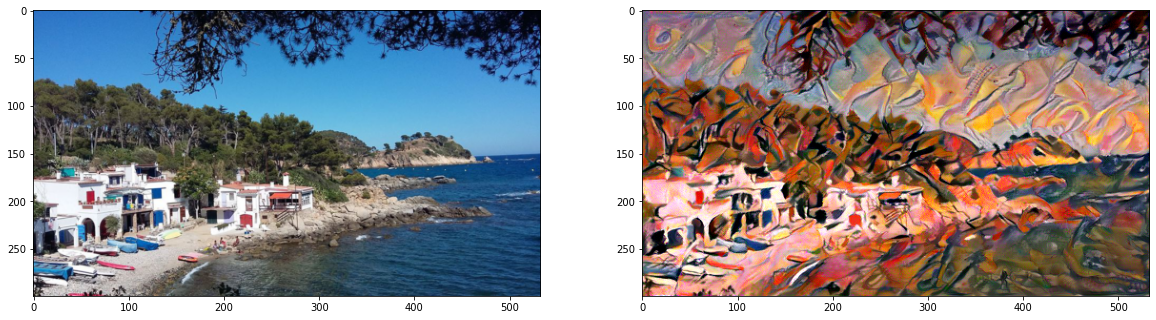

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

## Almacenamiento en local
Por último, si queremos conservar la imagen resultante, podemos bajarla imagen a nuestro ordenador.

In [ ]:
from google.colab import files
target_path = "content_style.jpg"

target_im = im_convert(target)
target_im = target_im * 255
target_im = target_im.astype('uint8')
Image.fromarray(target_im).save(target_path)

files.download(target_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Preguntas
### 1 - ¿Cuántas capas lineales contiene el clasificador de VGG19

Se puede notar que el clasificador (vgg_classifier) contiene 3 capas lineales según la imagen de debajo:

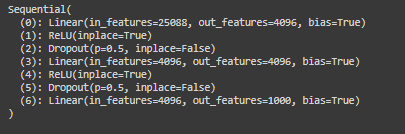

Las capas lineales son:
1 capa de entrada donde se recogen las variables de entrada y se devuelve 4096 nodos a la siguiente capa.7

Una segunda capa de entrada que recoge y devuelve la misma cantidad de nodos (4096) y que viene precedida por una función de activación ReLU y un dropout del 50%.

Por último, una capa de salida que devuelve 1000 clases posibles. Al igual que en el caso anterior, viene precedida por una función de activación ReLU y un dropout del 50%.


### 2 - ¿Cuántas clases distintas puede reconocer VGG19 en su configuración original?

Como se señaló anteriormente, el clasificador de VGG podría identificar 1000 clases distintas; esto se puede ver en la arquitectura del modelo en su última capa (6) y su parámetro *out_features*.

### 3 - Indica los identificadores de capas convolucionales a continuación de capas de max pooling

En el modelo hay cuatro capas convolucionales que vienen posteriormente a las capas reductoras de pooling. Cabe mencionar que se utilizan también otras capas convolucionales en otras etapas de la red, pero dichas capas no vienen a continuación del max pooling.

**La primer capa con estas características es:**

Conv2d(64,128, kernel_size = (3,3), stride= (1,1), padding= (1,1))

Inicialmente, ingresan 64 nodos y el output del modelo serán 128. El tamaño del kernel será una matriz de 3x3.

**Segunda capa:**

Conv2d(128, 256, kernel_size= (3,3), stride= (1,1), padding= (1,1))

En esta capa se duplican los nodos de salida a 256.

**Tercera capa:**

Conv2d(256, 512, kernel_size= (3,3), stride= (1,1), padding= (1,1))

Nuevamente se duplican los nodos a la salida, generando 512.

**Cuarta capa:**

Conv2d(512, 512, kernel_size= (3,3), stride= (1,1), padding= (1,1))




### 4 - ¿Qué influencia tienen los cambios solicitados (content_weight, style_weight, learning rate, steps) en las imágenes intermedias y en la imagen resultante?

Para este ejercicio, todas las modificaciones fueron realizadas para el parámetro en concreto a analizar y manteniendo constante el resto de los argumentos.

Con respecto a las modificaciones en content y style_weight se puede notar que, como los nombres de las variables lo indican, estos multiplicadores le dan mayor o menor preponderancia a las imágenes. Esto quiere decir que si el valor de ambas variables fuera 1, su peso sería el mismo y la pérdida total sería simplemente la suma de ambas pérdidas. Dado lo anterior, si style_weigth es notoriamente mas grande que content_weight, la imagen tendrá una fuerte influencia de la imagen de estilo y consecuentemente la pérdida general del modelo será mayor. Esta pérdida general será mayor debido al hecho de que no se logra recomponer la imagen de contenido y, al estar tan influida por la foto de estilo, dista mucho mas de su versión original.

**Versión:**

content_weight = 1

style_weight = 1e6

Loss de cada iteración:
[1874767.0, 865223.3125, 716772.625, 710497.0625, 496636.25]

Imagen generada:

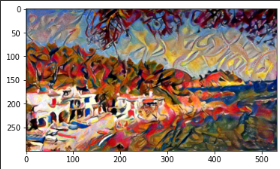


**Versión:**

content_weight = 1e2

style_weight = 1e2

Loss de cada iteración:
[912.0494384765625, 727.0867919921875, 711.3529052734375, 662.1107177734375, 594.5087890625]

Imagen generada:

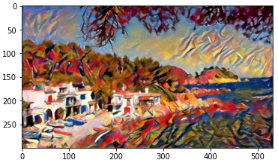

En este caso, a nivel empírico, puede parecer que es la misma imagen que el ejemplo anterior, sin embargo no es el caso. Su pérdida general es menor, lo cual nos da a entender que la fotografía de contenido está mejor "recompuesta" por el modelo que en el caso anterior. Esto se puede notar a simple vista en algunas regiones de la imagen (ej.: el cielo no tiene tanta influencia de la fotografía de estilo como en el ejemplo anterior).

**Versión:**

content_weight = 1e2

style_weight = 1e-2

Loss de cada iteración:
[10.291152000427246, 7.158910751342773, 6.088266372680664, 5.930665016174316, 5.978862762451172]


Imagen generada:

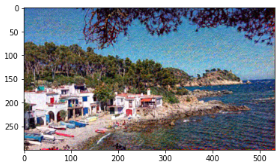

En este último ejemplo, se puede ver claramente la influencia de los weights en el resultado final. Dado que la influencia de de content_weight es 100 y de style weight es 0.01, el modelo al realizar el algoritmo de backpropagation quedará fuertemente influido por la pérdida de la imagen de contenido. Esto implicará una pérdida menor (la imagen de estilo tendrá su pérdida fuertemente reducida por el efecto multiplicador de style weight) y, por lo tanto, una mayor capacidad del modelo de regenerar la imagen original sin la influencia de la fotografía de estilo.


Con respecto al learning rate, se entiende que una mayor tasa de learning rate genera un modelo menos efectivo pero que requiere menor tiempo computacional. Esto radica en el hecho de que la learning rate, es la tasa de "velocidad en aprender" del modelo donde, dependiendo de su valor, el modelo ajustará los pesos por medio del optimizador una vez ejecutado el algoritmo de backpropagation. Con esto en mente, podemos suponer que para este ejercicio en particular una baja tasa de learning rate generará una imagen mas similar a la de contenido original y una tasa alta implicará un menor tiempo de cómputo del modelo y una imagen que va adquiriendo cada vez mas información de la imagen de estilo conjuntamente a la de contenido.

**Versión 1:**

Learning Rate: 0.003

Loss: [190951024.0, 87705648.0, 49038128.0, 31155832.0, 21661232.0]

Imagen:

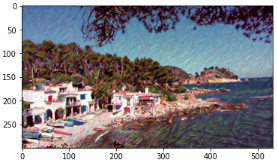

**Versión 2:**

Learning Rate: 0.01

Loss: [42724608.0, 14498179.0, 7917565.5, 5237561.5, 3823377.5]

Imagen:

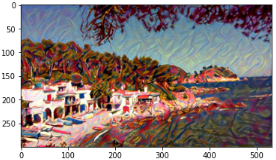

Como se puede observar, la pérdida a la tasa de 0.01 es significativamente menor al caso de 0.003. Esto se debe a que, manteniendo constante la cantidad de iteraciones, el modelo a 0.003 "aprende mas rápido" de los errores en los que incurre y el optimizador le da mayor importancia la pérdida generada en la etapa forward. A misma cantidad de iteraciones, el modelo ajusta mas rapidamente en esta versión, lo que significa empíricamente que la imagen se "fusiona" mas rapidamente con la imagen de estilo.

**Versión 3:**

Learning Rate: 0.1

Loss: [1872107.25, 864207.25, 793777.375, 609513.375, 445090.125]

Imagen:

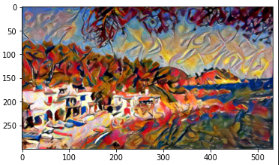

Este último ejemplo confirma lo mencionado en el caso anterior: una mayor learning rate ajusta mas rápido el modelo, buscando el mínimo de errores y arriesgando la accurracy como contracara. El modelo ajusta mas rápidamente, la pérdida se encuentra cada vez mas fuertemente influenciada por la imagen de estilo y, consecuentemente, la accuracy del modelo respecto a la imagen original queda notoriamente comprometida.


De la mano con lo anterior, un incremento en la cantidad de iteraciones (con el resto de los hiperparámetros constantes) generará un descenso progresivo de la pérdida en cada iteración ya que el modelo contará con mas instancias de reotralimentación. Esto no necesariamente es lo óptimo siempre, ya que se puede pasar del overfitting al óptimo para posteriormente incurrir en overfitting cuando la cantidad de iteraciones es muy alta.

**Versión 1:**

Iteraciones: 500

Loss: [1875571.0, 865882.375, 688189.6875, 1890274.125, 403841.46875]

Imagen:

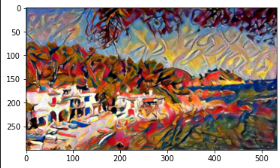

**Versión 2:**

Iteraciones: 1000

Loss: [1872611.0, 863905.0625, 635795.4375, 570257.1875, 2469941.0, 393865.5, 457291.3125, 425091.34375, 279579.4375, 313338.375]

Imagen:

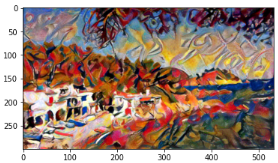

**Versión 3:**

Iteraciones: 2000

Loss: [1874337.125, 864561.8125, 712824.625, 1384258.625, 393580.0, 1482249.75, 425889.09375, 359898.4375, 444130.375, 342131.09375, 284565.5, 2206439.25, 297048.21875, 258919.25, 1629707.0, 341086.84375, 303179.25, 238169.78125, 3507469.75, 328705.0]

Imagen:

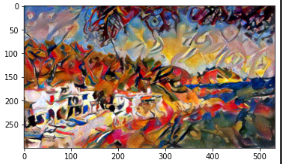

En los ejemplos se puede ver que las pérdidas, con todo el resto de hiperparámetros constantes, van disminuyendo notoriamente y la imagen es mas fuertemente influenciada por la imagen de estilo.